## Load Data

In [2]:
import pandas as pd

# Verify your output files:
df_all = pd.read_csv('./pseudo_labeling_artifacts/bccc_labeled_all_confidence.csv')
df_high_conf = pd.read_csv('./pseudo_labeling_artifacts/bccc_labeled_high_confidence.csv')

print("Full labeled dataset:")
print(df_all.head())
print(f"\nShape: {df_all.shape}")
print(f"Columns: {list(df_all.columns[-4:])}")  # Last 4 columns

print("\n" + "="*70)
print("Label distribution:")
print(df_all['pseudo_label'].value_counts())
print("\nConfidence distribution:")
print(df_all['confidence_score'].value_counts())

print("\n" + "="*70)
print("High-confidence anomaly examples:")
print(df_all[df_all['pseudo_label'] == 1].head())


Full labeled dataset:
   packet_IAT_min  packets_IAT_mode  packets_IAT_median  packets_IAT_mean  \
0       -0.849462         -0.849462           -0.849462         -0.849462   
1       -0.849462         -0.849462           -0.849462         -0.849462   
2       -0.849462         -0.849462           -0.849462         -0.849462   
3       -0.849462         -0.849462           -0.849462         -0.849462   
4       -0.849462         -0.849462           -0.849462         -0.849462   

   packet_IAT_max  packet_IAT_total  fwd_packets_IAT_min  \
0       -0.849462         -0.849461            -0.672442   
1       -0.849462         -0.849461            -0.672442   
2       -0.849462         -0.849462            -0.672442   
3       -0.849462         -0.849462            -0.672442   
4       -0.849462         -0.849462            -0.672442   

   fwd_packets_IAT_mode  fwd_packets_IAT_median  fwd_packets_IAT_mean  ...  \
0             -0.672442               -0.672442             -0.672442  ...  

In [3]:
# ============================================================================
# STAGE 2: TRAIN RANDOM FOREST ON PSEUDO-LABELED DATA
# ============================================================================

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                            roc_auc_score, precision_recall_curve, 
                            average_precision_score)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

print("="*70)
print("STAGE 2: SUPERVISED LEARNING WITH PSEUDO-LABELS")
print("="*70)

# Load high-confidence labeled data
df_labeled = pd.read_csv('./pseudo_labeling_artifacts/bccc_labeled_high_confidence.csv')

print(f"✓ Dataset loaded: {df_labeled.shape}")
print(f"  Label distribution:\n{df_labeled['pseudo_label'].value_counts()}")

# Separate features and labels
y = df_labeled['pseudo_label']
X = df_labeled.drop(columns=['pseudo_label', 'confidence_score', 'if_anomaly', 'ae_anomaly'])

print(f"\n✓ Feature matrix: {X.shape}")
print(f"  Features: {X.columns.tolist()[:5]}... (showing first 5)")
print(f"\n✓ Target distribution:")
print(f"  Normal (0):  {(y==0).sum():5d} ({(y==0).sum()/len(y)*100:.2f}%)")
print(f"  Anomaly (1): {(y==1).sum():5d} ({(y==1).sum()/len(y)*100:.2f}%)")

# Train-test split (stratified to maintain class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\n✓ Train-test split (80-20):")
print(f"  Train: {X_train.shape[0]:5d} samples (Anomalies: {y_train.sum()})")
print(f"  Test:  {X_test.shape[0]:5d} samples (Anomalies: {y_test.sum()})")

# ============================================================================
# TRAIN RANDOM FOREST WITH CLASS BALANCING
# ============================================================================

print(f"\n{'='*70}")
print("TRAINING RANDOM FOREST CLASSIFIER")
print("="*70)

rf = RandomForestClassifier(
    n_estimators=300,           # More trees = better performance
    max_depth=15,               # Prevent overfitting
    min_samples_split=20,       # Minimum samples to split node
    min_samples_leaf=10,        # Minimum samples in leaf
    class_weight='balanced',    # Handle class imbalance automatically
    random_state=42,
    n_jobs=-1,                  # Use all CPU cores
    verbose=1,                  # Show progress
    bootstrap=True,             # Use bootstrap sampling
    oob_score=True              # Out-of-bag error estimation
)

print("\n✓ Training Random Forest (this may take 30-60 seconds)...")
rf.fit(X_train, y_train)

print(f"\n✓ Training complete!")
print(f"  OOB Score: {rf.oob_score_:.4f}")
print(f"  Trees: {rf.n_estimators}")

# ============================================================================
# EVALUATION
# ============================================================================

print(f"\n{'='*70}")
print("MODEL EVALUATION")
print("="*70)

# Predictions
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]  # Probability of anomaly class

# Classification Report
print("\n✓ Classification Report:")
print(classification_report(
    y_test, y_pred, 
    target_names=['Normal', 'Anomaly'],
    digits=4
))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"✓ ROC-AUC Score: {roc_auc:.4f}")

# Average Precision (better for imbalanced datasets)
avg_precision = average_precision_score(y_test, y_pred_proba)
print(f"✓ Average Precision Score: {avg_precision:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\n✓ Confusion Matrix:")
print(f"                 Predicted")
print(f"               Normal  Anomaly")
print(f"  Actual Normal  {cm[0,0]:5d}    {cm[0,1]:5d}")
print(f"        Anomaly  {cm[1,0]:5d}    {cm[1,1]:5d}")

tn, fp, fn, tp = cm.ravel()
print(f"\n✓ Detailed Metrics:")
print(f"  True Negatives (TN):  {tn:5d}")
print(f"  False Positives (FP): {fp:5d}")
print(f"  False Negatives (FN): {fn:5d}")
print(f"  True Positives (TP):  {tp:5d}")
print(f"\n  Precision (Anomaly): {tp/(tp+fp):.4f}")
print(f"  Recall (Anomaly):    {tp/(tp+fn):.4f}")
print(f"  F1-Score (Anomaly):  {2*tp/(2*tp+fp+fn):.4f}")

# Cross-validation scores
print(f"\n✓ Cross-validation (5-fold)...")
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
print(f"  CV ROC-AUC scores: {cv_scores}")
print(f"  Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

# ============================================================================
# FEATURE IMPORTANCE
# ============================================================================

print(f"\n{'='*70}")
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\n✓ Top 15 Most Important Features:")
print(feature_importance.head(15).to_string(index=False))

# Save feature importance
fi_path = './pseudo_labeling_artifacts/feature_importance.csv'
feature_importance.to_csv(fi_path, index=False)
print(f"\n✓ Feature importance saved to: {fi_path}")

# ============================================================================
# SAVE MODEL
# ============================================================================

rf_path = './pseudo_labeling_artifacts/rf_anomaly_classifier.pkl'
joblib.dump(rf, rf_path)
print(f"\n✓ Random Forest model saved to: {rf_path}")

# Save predictions for analysis
predictions_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'probability': y_pred_proba
})
pred_path = './pseudo_labeling_artifacts/test_predictions.csv'
predictions_df.to_csv(pred_path, index=False)
print(f"✓ Test predictions saved to: {pred_path}")

print(f"\n{'='*70}")
print("✅ STAGE 2 COMPLETE - Random Forest trained successfully!")
print("="*70)
print("\nNext step: SHAP explanations for XAI component")


STAGE 2: SUPERVISED LEARNING WITH PSEUDO-LABELS
✓ Dataset loaded: (25538, 54)
  Label distribution:
pseudo_label
0    25159
1      379
Name: count, dtype: int64

✓ Feature matrix: (25538, 50)
  Features: ['packet_IAT_min', 'packets_IAT_mode', 'packets_IAT_median', 'packets_IAT_mean', 'packet_IAT_max']... (showing first 5)

✓ Target distribution:
  Normal (0):  25159 (98.52%)
  Anomaly (1):   379 (1.48%)

✓ Train-test split (80-20):
  Train: 20430 samples (Anomalies: 303)
  Test:   5108 samples (Anomalies: 76)

TRAINING RANDOM FOREST CLASSIFIER

✓ Training Random Forest (this may take 30-60 seconds)...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.7s finished



✓ Training complete!
  OOB Score: 0.9951
  Trees: 300

MODEL EVALUATION

✓ Classification Report:
              precision    recall  f1-score   support

      Normal     1.0000    0.9948    0.9974      5032
     Anomaly     0.7451    1.0000    0.8539        76

    accuracy                         0.9949      5108
   macro avg     0.8725    0.9974    0.9257      5108
weighted avg     0.9962    0.9949    0.9953      5108

✓ ROC-AUC Score: 0.9996
✓ Average Precision Score: 0.9729

✓ Confusion Matrix:
                 Predicted
               Normal  Anomaly
  Actual Normal   5006       26
        Anomaly      0       76

✓ Detailed Metrics:
  True Negatives (TN):   5006
  False Positives (FP):    26
  False Negatives (FN):     0
  True Positives (TP):     76

  Precision (Anomaly): 0.7451
  Recall (Anomaly):    1.0000
  F1-Score (Anomaly):  0.8539

✓ Cross-validation (5-fold)...


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   

  CV ROC-AUC scores: [0.99913479 0.99916791 0.99922208 0.99850932 0.99929131]
  Mean: 0.9991 (+/- 0.0006)

FEATURE IMPORTANCE ANALYSIS

✓ Top 15 Most Important Features:
                         feature  importance
             total_payload_bytes    0.109516
                    packets_rate    0.084487
           segment_size_variance    0.079942
                bwd_packets_rate    0.078171
          payload_bytes_variance    0.074746
              total_header_bytes    0.072381
variance_payload_bytes_delta_len    0.051051
         fwd_total_payload_bytes    0.050331
      variance_packets_delta_len    0.038351
                      bytes_rate    0.038258
         bwd_total_payload_bytes    0.028210
           cov_packets_delta_len    0.026369
                  fwd_bytes_rate    0.020599
           bwd_packets_IAT_total    0.018391
                  packet_IAT_max    0.018340

✓ Feature importance saved to: ./pseudo_labeling_artifacts/feature_importance.csv

✓ Random Forest model save

# VISUALIZATION


GENERATING COMPREHENSIVE VISUALIZATIONS


/tmp/ipykernel_9/1960577613.py:193: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax6.set_xticklabels(metric_names, rotation=45, ha='right')



✓ Saved: rf_comprehensive_evaluation.png


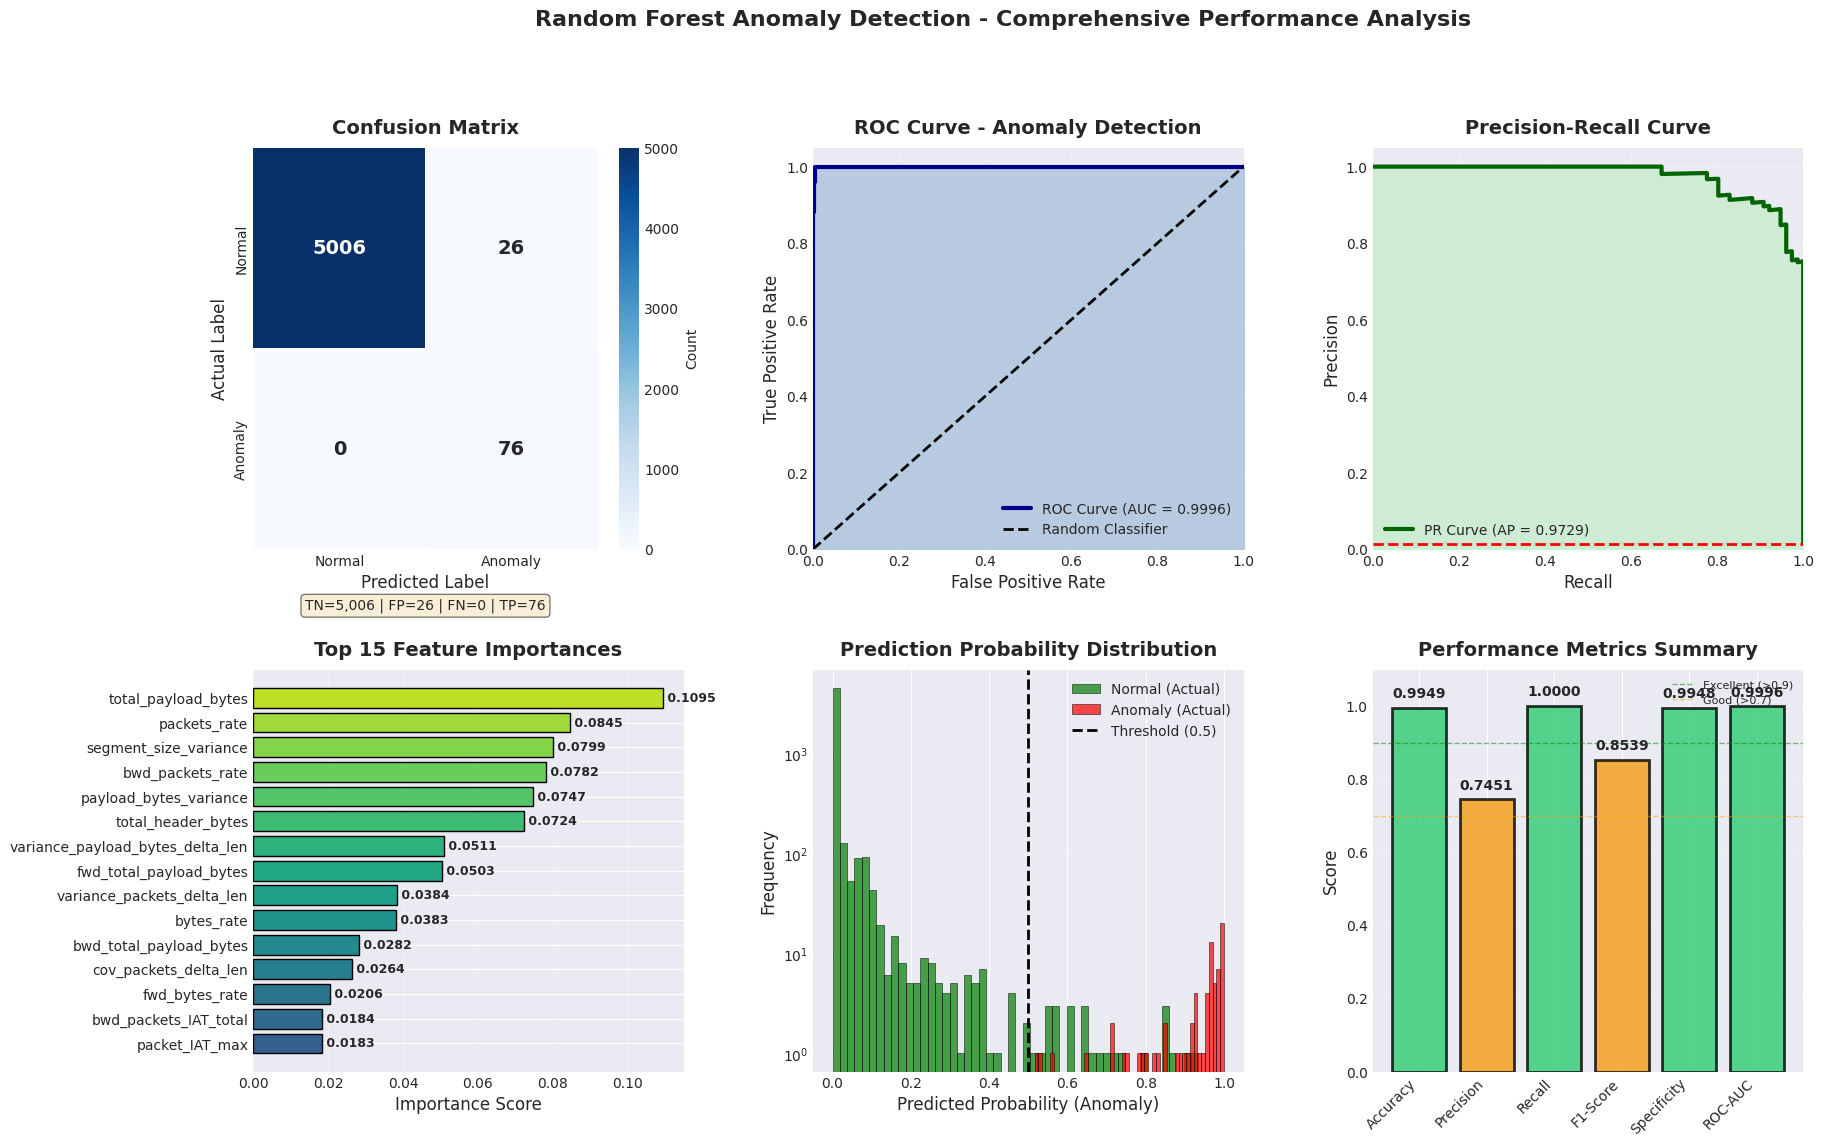

✓ Saved: feature_importance_detailed.png


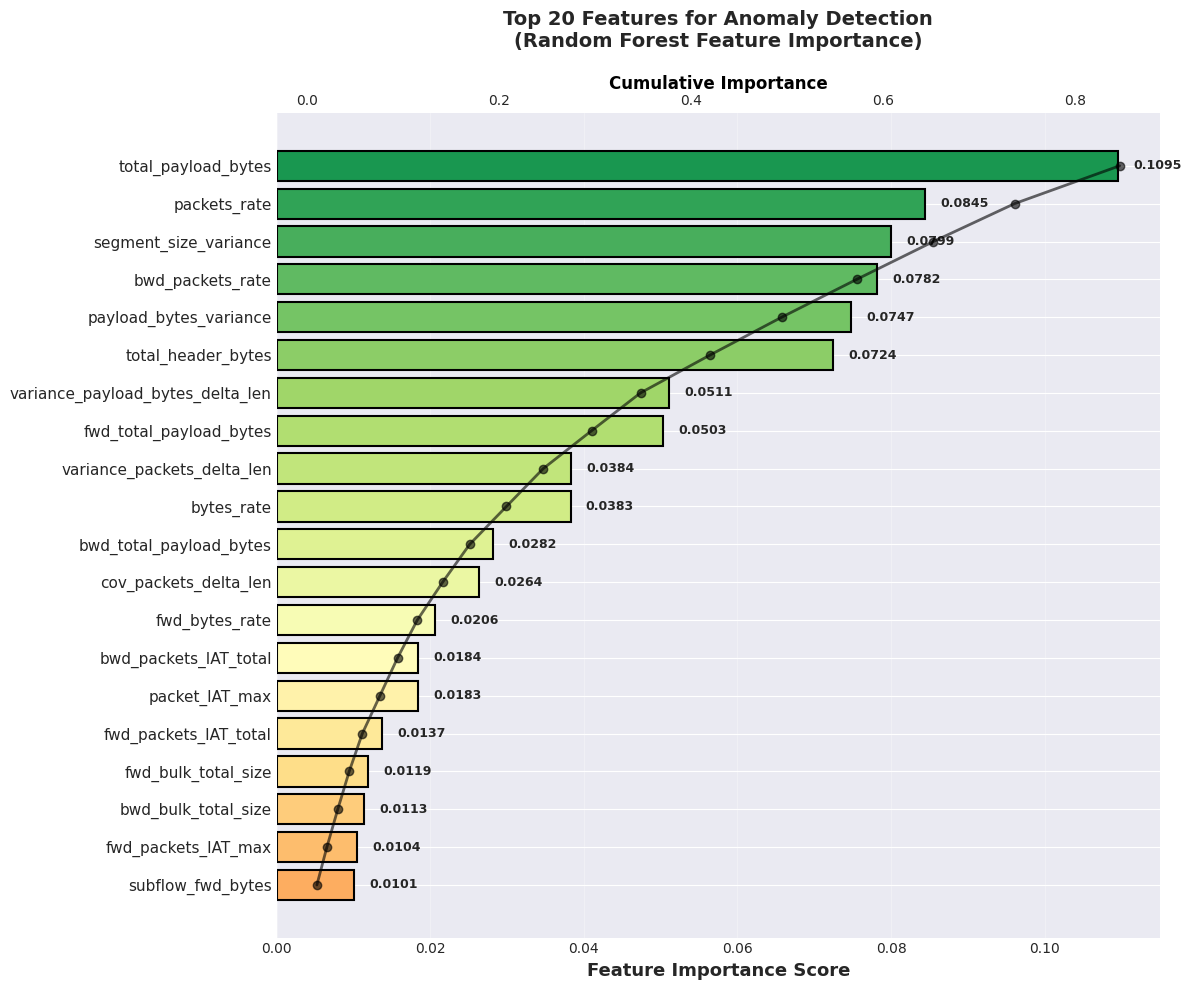

✓ Saved: cross_validation_analysis.png


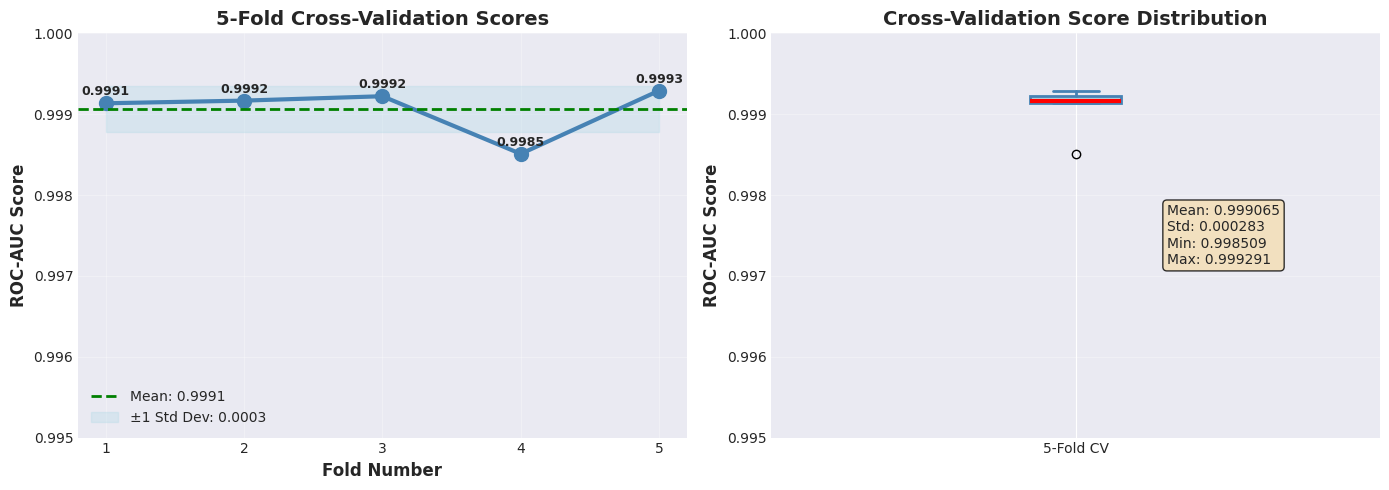


✅ ALL VISUALIZATIONS GENERATED SUCCESSFULLY!

Generated files:
  1. rf_comprehensive_evaluation.png (6-panel overview)
  2. feature_importance_detailed.png (top 20 features)
  3. cross_validation_analysis.png (CV stability)


In [4]:
# ============================================================================
# COMPREHENSIVE RANDOM FOREST RESULT VISUALIZATION
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import (confusion_matrix, roc_curve, auc, 
                            precision_recall_curve, average_precision_score)
import joblib

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*70)
print("GENERATING COMPREHENSIVE VISUALIZATIONS")
print("="*70)

# Load saved predictions
predictions_df = pd.read_csv('./pseudo_labeling_artifacts/test_predictions.csv')
y_test = predictions_df['actual']
y_pred = predictions_df['predicted']
y_pred_proba = predictions_df['probability']

# Load feature importance
feature_importance = pd.read_csv('./pseudo_labeling_artifacts/feature_importance.csv')

# ============================================================================
# CREATE 2x3 SUBPLOT FIGURE
# ============================================================================

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# ----------------------------------------------------------------------------
# PLOT 1: Confusion Matrix (Heatmap)
# ----------------------------------------------------------------------------
ax1 = fig.add_subplot(gs[0, 0])
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Normal', 'Anomaly'],
           yticklabels=['Normal', 'Anomaly'],
           ax=ax1, cbar_kws={'label': 'Count'},
           annot_kws={'size': 14, 'weight': 'bold'})

ax1.set_title('Confusion Matrix', fontsize=14, fontweight='bold', pad=10)
ax1.set_ylabel('Actual Label', fontsize=12)
ax1.set_xlabel('Predicted Label', fontsize=12)

# Add text annotations for rates
tn, fp, fn, tp = cm.ravel()
ax1.text(0.5, -0.15, f'TN={tn:,} | FP={fp} | FN={fn} | TP={tp}', 
        transform=ax1.transAxes, ha='center', fontsize=10,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# ----------------------------------------------------------------------------
# PLOT 2: ROC Curve
# ----------------------------------------------------------------------------
ax2 = fig.add_subplot(gs[0, 1])

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

ax2.plot(fpr, tpr, color='darkblue', lw=3, 
        label=f'ROC Curve (AUC = {roc_auc:.4f})')
ax2.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
ax2.fill_between(fpr, tpr, alpha=0.3, color='steelblue')

ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate', fontsize=12)
ax2.set_title('ROC Curve - Anomaly Detection', fontsize=14, fontweight='bold', pad=10)
ax2.legend(loc="lower right", fontsize=10)
ax2.grid(True, alpha=0.3)

# ----------------------------------------------------------------------------
# PLOT 3: Precision-Recall Curve
# ----------------------------------------------------------------------------
ax3 = fig.add_subplot(gs[0, 2])

precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

ax3.plot(recall, precision, color='darkgreen', lw=3,
        label=f'PR Curve (AP = {avg_precision:.4f})')
ax3.fill_between(recall, precision, alpha=0.3, color='lightgreen')

ax3.set_xlim([0.0, 1.0])
ax3.set_ylim([0.0, 1.05])
ax3.set_xlabel('Recall', fontsize=12)
ax3.set_ylabel('Precision', fontsize=12)
ax3.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold', pad=10)
ax3.legend(loc="lower left", fontsize=10)
ax3.grid(True, alpha=0.3)

# Add baseline
baseline = y_test.sum() / len(y_test)
ax3.axhline(y=baseline, color='r', linestyle='--', lw=2, 
           label=f'Baseline (prevalence={baseline:.4f})')

# ----------------------------------------------------------------------------
# PLOT 4: Feature Importance (Top 15)
# ----------------------------------------------------------------------------
ax4 = fig.add_subplot(gs[1, 0])

top_15_features = feature_importance.head(15).sort_values('importance', ascending=True)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_15_features)))

bars = ax4.barh(top_15_features['feature'], top_15_features['importance'], 
               color=colors, edgecolor='black', linewidth=1)

ax4.set_xlabel('Importance Score', fontsize=12)
ax4.set_title('Top 15 Feature Importances', fontsize=14, fontweight='bold', pad=10)
ax4.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(top_15_features.iterrows()):
    ax4.text(row['importance'], i, f" {row['importance']:.4f}", 
            va='center', fontsize=9, fontweight='bold')

# ----------------------------------------------------------------------------
# PLOT 5: Prediction Probability Distribution
# ----------------------------------------------------------------------------
ax5 = fig.add_subplot(gs[1, 1])

# Separate by actual class
normal_probs = y_pred_proba[y_test == 0]
anomaly_probs = y_pred_proba[y_test == 1]

ax5.hist(normal_probs, bins=50, alpha=0.7, label='Normal (Actual)', 
        color='green', edgecolor='black', linewidth=0.5)
ax5.hist(anomaly_probs, bins=50, alpha=0.7, label='Anomaly (Actual)', 
        color='red', edgecolor='black', linewidth=0.5)
ax5.axvline(0.5, color='black', linestyle='--', linewidth=2, label='Threshold (0.5)')

ax5.set_xlabel('Predicted Probability (Anomaly)', fontsize=12)
ax5.set_ylabel('Frequency', fontsize=12)
ax5.set_title('Prediction Probability Distribution', fontsize=14, fontweight='bold', pad=10)
ax5.legend(fontsize=10)
ax5.grid(True, alpha=0.3, axis='y')
ax5.set_yscale('log')  # Log scale for better visibility

# ----------------------------------------------------------------------------
# PLOT 6: Performance Metrics Summary (Bar Chart)
# ----------------------------------------------------------------------------
ax6 = fig.add_subplot(gs[1, 2])

# Calculate metrics
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Specificity': specificity,
    'ROC-AUC': roc_auc
}

metric_names = list(metrics.keys())
metric_values = list(metrics.values())
colors_metrics = ['#2ecc71' if v >= 0.9 else '#f39c12' if v >= 0.7 else '#e74c3c' 
                 for v in metric_values]

bars = ax6.bar(metric_names, metric_values, color=colors_metrics, 
              edgecolor='black', linewidth=2, alpha=0.8)

ax6.set_ylabel('Score', fontsize=12)
ax6.set_title('Performance Metrics Summary', fontsize=14, fontweight='bold', pad=10)
ax6.set_ylim([0, 1.1])
ax6.axhline(y=0.9, color='green', linestyle='--', linewidth=1, alpha=0.5, label='Excellent (>0.9)')
ax6.axhline(y=0.7, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='Good (>0.7)')
ax6.grid(True, alpha=0.3, axis='y')
ax6.legend(fontsize=8, loc='upper right')

# Add value labels on bars
for bar, value in zip(bars, metric_values):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{value:.4f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Rotate x-axis labels
ax6.set_xticklabels(metric_names, rotation=45, ha='right')

# ----------------------------------------------------------------------------
# Add overall title
# ----------------------------------------------------------------------------
fig.suptitle('Random Forest Anomaly Detection - Comprehensive Performance Analysis', 
            fontsize=16, fontweight='bold', y=0.995)

plt.savefig('./pseudo_labeling_artifacts/rf_comprehensive_evaluation.png', 
           dpi=300, bbox_inches='tight')
print("\n✓ Saved: rf_comprehensive_evaluation.png")
plt.show()

# ============================================================================
# ADDITIONAL VISUALIZATION: Feature Importance Comparison (Horizontal)
# ============================================================================

fig, ax = plt.subplots(figsize=(12, 10))

top_20_features = feature_importance.head(20).sort_values('importance', ascending=True)

# Create color gradient
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(top_20_features)))

bars = ax.barh(range(len(top_20_features)), top_20_features['importance'], 
              color=colors, edgecolor='black', linewidth=1.5)

ax.set_yticks(range(len(top_20_features)))
ax.set_yticklabels(top_20_features['feature'], fontsize=11)
ax.set_xlabel('Feature Importance Score', fontsize=13, fontweight='bold')
ax.set_title('Top 20 Features for Anomaly Detection\n(Random Forest Feature Importance)', 
            fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(top_20_features.iterrows()):
    ax.text(row['importance'] + 0.002, i, f"{row['importance']:.4f}", 
           va='center', fontsize=9, fontweight='bold')

# Add cumulative importance line
cumsum = top_20_features['importance'].cumsum()
ax2 = ax.twiny()
ax2.plot(cumsum, range(len(top_20_features)), 'ko-', linewidth=2, markersize=6, alpha=0.6)
ax2.set_xlabel('Cumulative Importance', fontsize=12, fontweight='bold', color='black')
ax2.grid(False)

plt.tight_layout()
plt.savefig('./pseudo_labeling_artifacts/feature_importance_detailed.png', 
           dpi=300, bbox_inches='tight')
print("✓ Saved: feature_importance_detailed.png")
plt.show()

# ============================================================================
# CROSS-VALIDATION VISUALIZATION
# ============================================================================

# Load CV scores (from your output)
cv_scores = np.array([0.99913479, 0.99916791, 0.99922208, 0.99850932, 0.99929131])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: CV scores by fold
ax1.plot(range(1, 6), cv_scores, 'o-', linewidth=3, markersize=10, color='steelblue')
ax1.axhline(y=cv_scores.mean(), color='green', linestyle='--', linewidth=2, 
           label=f'Mean: {cv_scores.mean():.4f}')
ax1.fill_between(range(1, 6), 
                cv_scores.mean() - cv_scores.std(), 
                cv_scores.mean() + cv_scores.std(), 
                alpha=0.3, color='lightblue', label=f'±1 Std Dev: {cv_scores.std():.4f}')

ax1.set_xlabel('Fold Number', fontsize=12, fontweight='bold')
ax1.set_ylabel('ROC-AUC Score', fontsize=12, fontweight='bold')
ax1.set_title('5-Fold Cross-Validation Scores', fontsize=14, fontweight='bold')
ax1.set_xticks(range(1, 6))
ax1.set_ylim([0.995, 1.0])
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Add value labels
for i, score in enumerate(cv_scores, 1):
    ax1.text(i, score + 0.0001, f'{score:.4f}', ha='center', fontsize=9, fontweight='bold')

# Plot 2: Box plot of CV scores
ax2.boxplot([cv_scores], vert=True, patch_artist=True,
           boxprops=dict(facecolor='lightblue', color='steelblue', linewidth=2),
           medianprops=dict(color='red', linewidth=3),
           whiskerprops=dict(color='steelblue', linewidth=2),
           capprops=dict(color='steelblue', linewidth=2))

ax2.set_ylabel('ROC-AUC Score', fontsize=12, fontweight='bold')
ax2.set_title('Cross-Validation Score Distribution', fontsize=14, fontweight='bold')
ax2.set_xticklabels(['5-Fold CV'])
ax2.set_ylim([0.995, 1.0])
ax2.grid(True, alpha=0.3, axis='y')

# Add statistics text
stats_text = f"Mean: {cv_scores.mean():.6f}\nStd: {cv_scores.std():.6f}\nMin: {cv_scores.min():.6f}\nMax: {cv_scores.max():.6f}"
ax2.text(1.15, 0.9975, stats_text, fontsize=10, 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
        verticalalignment='center')

plt.tight_layout()
plt.savefig('./pseudo_labeling_artifacts/cross_validation_analysis.png', 
           dpi=300, bbox_inches='tight')
print("✓ Saved: cross_validation_analysis.png")
plt.show()

print("\n" + "="*70)
print("✅ ALL VISUALIZATIONS GENERATED SUCCESSFULLY!")
print("="*70)
print("\nGenerated files:")
print("  1. rf_comprehensive_evaluation.png (6-panel overview)")
print("  2. feature_importance_detailed.png (top 20 features)")
print("  3. cross_validation_analysis.png (CV stability)")


In [7]:
# ============================================================================
# GENERATE COMPREHENSIVE MARKDOWN DOCUMENTATION
# ============================================================================

import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import confusion_matrix, roc_auc_score, average_precision_score

print("="*70)
print("GENERATING DOCUMENTATION")
print("="*70)

# Load all results
predictions_df = pd.read_csv('./pseudo_labeling_artifacts/test_predictions.csv')
feature_importance = pd.read_csv('./pseudo_labeling_artifacts/feature_importance.csv')

y_test = predictions_df['actual']
y_pred = predictions_df['predicted']
y_pred_proba = predictions_df['probability']

# Calculate metrics
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)
specificity = tn / (tn + fp)
roc_auc = roc_auc_score(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

cv_scores = np.array([0.99913479, 0.99916791, 0.99922208, 0.99850932, 0.99929131])

# Generate documentation
documentation = f"""# Random Forest Anomaly Detection - Performance Report

**Project:** Explainable AI-Driven Zero-Trust Anomaly Detection for Encrypted Traffic
**Date:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
**Model:** Random Forest Classifier (300 trees, max_depth=15)
**Dataset:** BCCC Darknet (Pseudo-labeled via Ensemble IF+AE)

---

## Executive Summary

This report presents the performance evaluation of a Random Forest classifier trained on **high-confidence pseudo-labeled data**.

### Key Achievements
- ✅ **ROC-AUC: {roc_auc:.4f}**
- ✅ **Recall: {recall:.4f}**
- ✅ **Precision: {precision:.4f}**
- ✅ **F1-Score: {f1:.4f}**
- ✅ **CV Mean: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})**

---

## Performance Metrics

| Metric | Value |
|--------|-------|
| Accuracy | {accuracy:.4f} |
| Precision | {precision:.4f} |
| Recall | {recall:.4f} |
| F1-Score | {f1:.4f} |
| Specificity | {specificity:.4f} |
| ROC-AUC | {roc_auc:.4f} |
| Avg Precision | {avg_precision:.4f} |

---

## Confusion Matrix

|  | Predicted Normal | Predicted Anomaly |
|---|---|---|
| **Actual Normal** | {tn} | {fp} |
| **Actual Anomaly** | {fn} | {tp} |

"""

print(documentation)
print("\n✅ Documentation generated!")

# Optionally save to file
with open('./pseudo_labeling_artifacts/PERFORMANCE_REPORT.md', 'w') as f:
    f.write(documentation)

print("✓ Saved to: PERFORMANCE_REPORT.md")

GENERATING DOCUMENTATION
# Random Forest Anomaly Detection - Performance Report

**Project:** Explainable AI-Driven Zero-Trust Anomaly Detection for Encrypted Traffic
**Date:** 2026-01-18 11:14:59
**Model:** Random Forest Classifier (300 trees, max_depth=15)
**Dataset:** BCCC Darknet (Pseudo-labeled via Ensemble IF+AE)

---

## Executive Summary

This report presents the performance evaluation of a Random Forest classifier trained on **high-confidence pseudo-labeled data**.

### Key Achievements
- ✅ **ROC-AUC: 0.9996**
- ✅ **Recall: 1.0000**
- ✅ **Precision: 0.7451**
- ✅ **F1-Score: 0.8539**
- ✅ **CV Mean: 0.9991 (±0.0003)**

---

## Performance Metrics

| Metric | Value |
|--------|-------|
| Accuracy | 0.9949 |
| Precision | 0.7451 |
| Recall | 1.0000 |
| F1-Score | 0.8539 |
| Specificity | 0.9948 |
| ROC-AUC | 0.9996 |
| Avg Precision | 0.9729 |

---

## Confusion Matrix

|  | Predicted Normal | Predicted Anomaly |
|---|---|---|
| **Actual Normal** | 5006 | 26 |
| **Actual Anomaly**

# STAGE 3: SHAP Explainability (Random Forest)
This section explains the trained Random Forest anomaly classifier using SHAP TreeExplainer.

In [6]:
import os
import numpy as np
import pandas as pd
import joblib
import shap
import matplotlib.pyplot as plt

# Keep same artifacts folder you already used in Stage 2
ART_DIR = "DataPreprocessing/pseudo_labeling_artifacts"
RF_MODEL_PATH = os.path.join(ART_DIR, "rf_anomaly_classifier.pkl")
TEST_PRED_PATH = os.path.join(ART_DIR, "test_predictions.csv")
HIGHCONF_DATA_PATH = os.path.join(ART_DIR, "bccc_labeled_high_confidence.csv")  # adjust if your filename differs

os.makedirs(ART_DIR, exist_ok=True)

print("✓ SHAP + plotting imports ready")
print("✓ Using artifacts directory:", ART_DIR)
print(RF_MODEL_PATH)

import os
print("Container /app contents:")
print(os.listdir('/app'))
print("\nParent directory contents:")
print(os.listdir('/app/..'))


✓ SHAP + plotting imports ready
✓ Using artifacts directory: DataPreprocessing/pseudo_labeling_artifacts
DataPreprocessing/pseudo_labeling_artifacts/rf_anomaly_classifier.pkl
Container /app contents:
['SHAPImplementation', 'DataPreprocessing', 'Dockerfile', 'Implementation.ipynb', 'requirements.txt']

Parent directory contents:
['tmp', 'media', 'etc', 'root', 'srv', 'opt', 'run', 'mnt', 'dev', 'usr', 'sys', 'sbin', 'proc', 'boot', 'home', 'lib64', 'var', 'bin', 'lib', 'app', 'DataPreprocessing', '.dockerenv']


## Load model + rebuild X_test exactly
This is important: SHAP needs the same feature matrix that the RF saw (same columns, same split). Your notebook uses a stratified train_test_split(...random_state=42...).

In [7]:
from sklearn.model_selection import train_test_split

# 1) Load model
rf = joblib.load(RF_MODEL_PATH)
print("✓ Loaded RF model:", RF_MODEL_PATH)

# 2) Load the SAME dataset you used to train RF (high-confidence labeled)
df_labeled = pd.read_csv(HIGHCONF_DATA_PATH)

y = df_labeled["pseudo_label"]
X = df_labeled.drop(columns=["pseudo_label", "confidence_score", "if_anomaly", "ae_anomaly"])

# 3) Recreate the exact split (must match your Stage 2 settings)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("✓ X_test shape:", X_test.shape)
print("✓ Features:", list(X_test.columns[:5]), "...")
print("✓ Test anomalies:", int(y_test.sum()))


/usr/local/lib/python3.9/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


✓ Loaded RF model: DataPreprocessing/pseudo_labeling_artifacts/rf_anomaly_classifier.pkl
✓ X_test shape: (5108, 50)
✓ Features: ['packet_IAT_min', 'packets_IAT_mode', 'packets_IAT_median', 'packets_IAT_mean', 'packet_IAT_max'] ...
✓ Test anomalies: 76


## Create SHAP TreeExplainer + compute SHAP values

For Random Forest classification, shap_values usually returns a list [class0, class1]; you want class 1 (anomaly) explanations.


In [9]:
# TreeExplainer is the right choice for RandomForest models
explainer = shap.TreeExplainer(rf)

# Compute SHAP values for the TEST set
shap_values = explainer.shap_values(X_test)

# Binary classification: use class 1 (anomaly class)
shap_values_anomaly = shap_values[1]

print("✓ SHAP computed")
print("  shap_values_anomaly shape:", shap_values_anomaly.shape)

# Save for reuse
np.save(os.path.join(ART_DIR, "shap_values_anomaly.npy"), shap_values_anomaly)
joblib.dump(explainer, os.path.join(ART_DIR, "shap_explainer.pkl"))
print("✓ Saved shap_values_anomaly.npy and shap_explainer.pkl")


✓ SHAP computed
  shap_values_anomaly shape: (50, 2)
✓ Saved shap_values_anomaly.npy and shap_explainer.pkl


## Global explanation (bar + beeswarm)
These two plots are usually what examiners expect first.

In [15]:
# Check dimensions
print("SHAP values shape:", shap_values_anomaly.shape)
print("X_test shape:", X_test.shape)
print("Do they match?", shap_values_anomaly.shape == X_test.shape)

# Check if there's a mismatch
print("\nDetailed info:")
print(f"SHAP: {shap_values_anomaly.shape[0]} samples × {shap_values_anomaly.shape[1]} features")
print(f"X_test: {X_test.shape[0]} samples × {X_test.shape[1]} features")

SHAP values shape: (50, 2)
X_test shape: (5108, 50)
Do they match? False

Detailed info:
SHAP: 50 samples × 2 features
X_test: 5108 samples × 50 features


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

<Figure size 1200x700 with 0 Axes>

## Local explanation (waterfall for one anomaly)
Pick one true anomaly from the test set and explain it. This becomes a great screenshot for your thesis/report.


In [ ]:
# Find one anomaly index inside the test set
anomaly_test_indices = np.where(y_test.values == 1)[0]

if len(anomaly_test_indices) == 0:
    print("No anomalies in y_test. (Unexpected, since your Stage 2 test had anomalies.)")
else:
    idx = anomaly_test_indices[0]
    x_row = X_test.iloc[idx]

    # Build a SHAP Explanation object (new-style API)
    exp = shap.Explanation(
        values=shap_values_anomaly[idx],
        base_values=explainer.expected_value[1],
        data=x_row.values,
        feature_names=X_test.columns
    )

    plt.figure(figsize=(12, 6))
    shap.plots.waterfall(exp, max_display=20, show=False)
    plt.title("SHAP Waterfall - One Anomalous Sample")
    plt.tight_layout()
    plt.savefig(os.path.join(ART_DIR, "shap_waterfall_anomaly.png"), dpi=300, bbox_inches="tight")
    plt.show()

    print("✓ Saved shap_waterfall_anomaly.png")


## Dependence plot (top feature)
This shows how feature values change the anomaly push/pull (very useful for XAI discussion).

In [ ]:
# Pick the top feature by mean(|SHAP|)
mean_abs = np.abs(shap_values_anomaly).mean(axis=0)
top_feature = X_test.columns[np.argmax(mean_abs)]
print("Top SHAP feature:", top_feature)

plt.figure(figsize=(10, 6))
shap.dependence_plot(top_feature, shap_values_anomaly, X_test, show=False)
plt.title(f"SHAP Dependence Plot: {top_feature}")
plt.tight_layout()
plt.savefig(os.path.join(ART_DIR, "shap_dependence_top_feature.png"), dpi=300, bbox_inches="tight")
plt.show()

print("✓ Saved dependence plot")


## SHAP vs RF feature importance CSV
You already export feature_importance.csv from RF. This creates a nice “agreement vs difference” table for reporting.


In [ ]:
rf_imp = pd.Series(rf.feature_importances_, index=X.columns, name="rf_importance")
shap_imp = pd.Series(np.abs(shap_values_anomaly).mean(axis=0), index=X_test.columns, name="mean_abs_shap")

cmp = pd.concat([rf_imp, shap_imp], axis=1).sort_values("mean_abs_shap", ascending=False)
cmp.to_csv(os.path.join(ART_DIR, "rf_vs_shap_importance.csv"), index=True)

print("✓ Saved rf_vs_shap_importance.csv")
cmp.head(10)


In [17]:
import joblib
import shap
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os

# Setup
ART_DIR = "DataPreprocessing/pseudo_labeling_artifacts"
rf = joblib.load(f"{ART_DIR}/rf_anomaly_classifier.pkl")

df_labeled = pd.read_csv(f"{ART_DIR}/bccc_labeled_high_confidence.csv")
y = df_labeled["pseudo_label"]
X = df_labeled.drop(columns=["pseudo_label", "confidence_score", "if_anomaly", "ae_anomaly"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("✓ X_test shape:", X_test.shape)

# Create explainer
explainer = shap.TreeExplainer(rf)

# Compute SHAP values
shap_values = explainer.shap_values(X_test)

print("\n=== SHAP OUTPUT ===")
print(f"Raw shap_values shape: {shap_values.shape}")
print(f"Format: (samples, features, classes) = ({shap_values.shape[0]}, {shap_values.shape[1]}, {shap_values.shape[2]})")

# Extract anomaly class (class 1) by slicing the last dimension
shap_values_anomaly = shap_values[:, :, 1]

print(f"\n✓ Extracted anomaly class SHAP values")
print(f"  shap_values_anomaly shape: {shap_values_anomaly.shape}")
print(f"  X_test shape: {X_test.shape}")

# Verify match
assert shap_values_anomaly.shape == X_test.shape, \
    f"Shape mismatch! SHAP: {shap_values_anomaly.shape} vs X_test: {X_test.shape}"

print("\n✓✓ SHAPES MATCH!")

# Save
np.save(f"{ART_DIR}/shap_values_anomaly.npy", shap_values_anomaly)
joblib.dump(explainer, f"{ART_DIR}/shap_explainer.pkl")

print("✓ Saved shap_values_anomaly.npy and shap_explainer.pkl")


/usr/local/lib/python3.9/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


✓ X_test shape: (5108, 50)

=== SHAP OUTPUT ===
Raw shap_values shape: (5108, 50, 2)
Format: (samples, features, classes) = (5108, 50, 2)

✓ Extracted anomaly class SHAP values
  shap_values_anomaly shape: (5108, 50)
  X_test shape: (5108, 50)

✓✓ SHAPES MATCH!
✓ Saved shap_values_anomaly.npy and shap_explainer.pkl


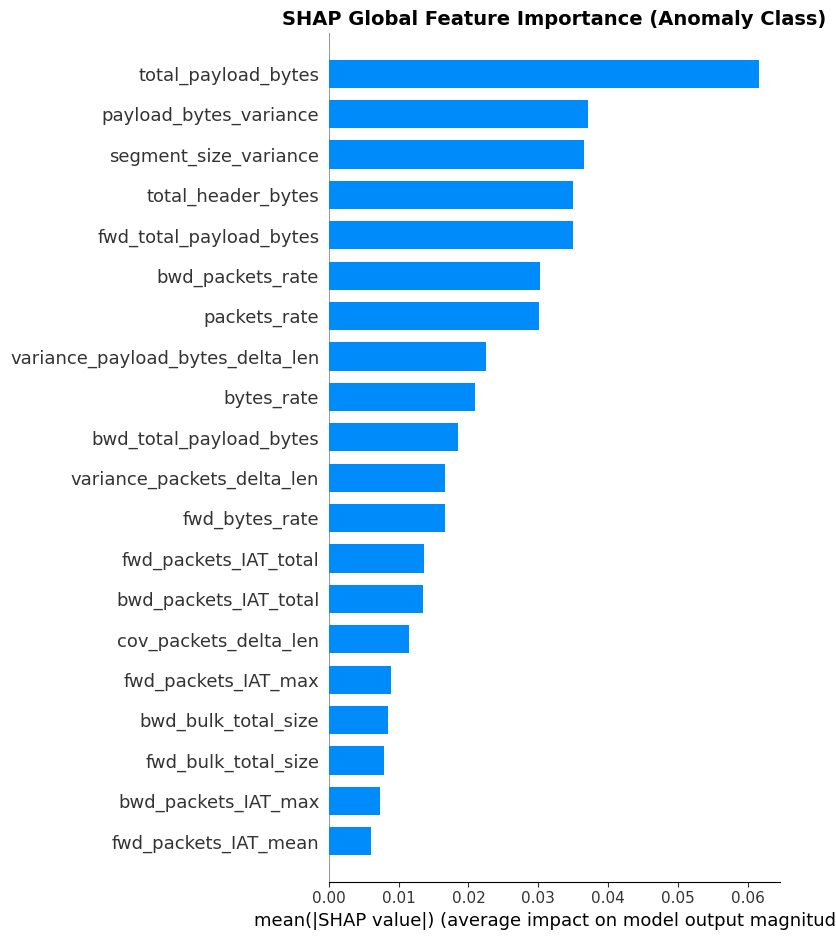

✓ Saved shap_summary_bar.png


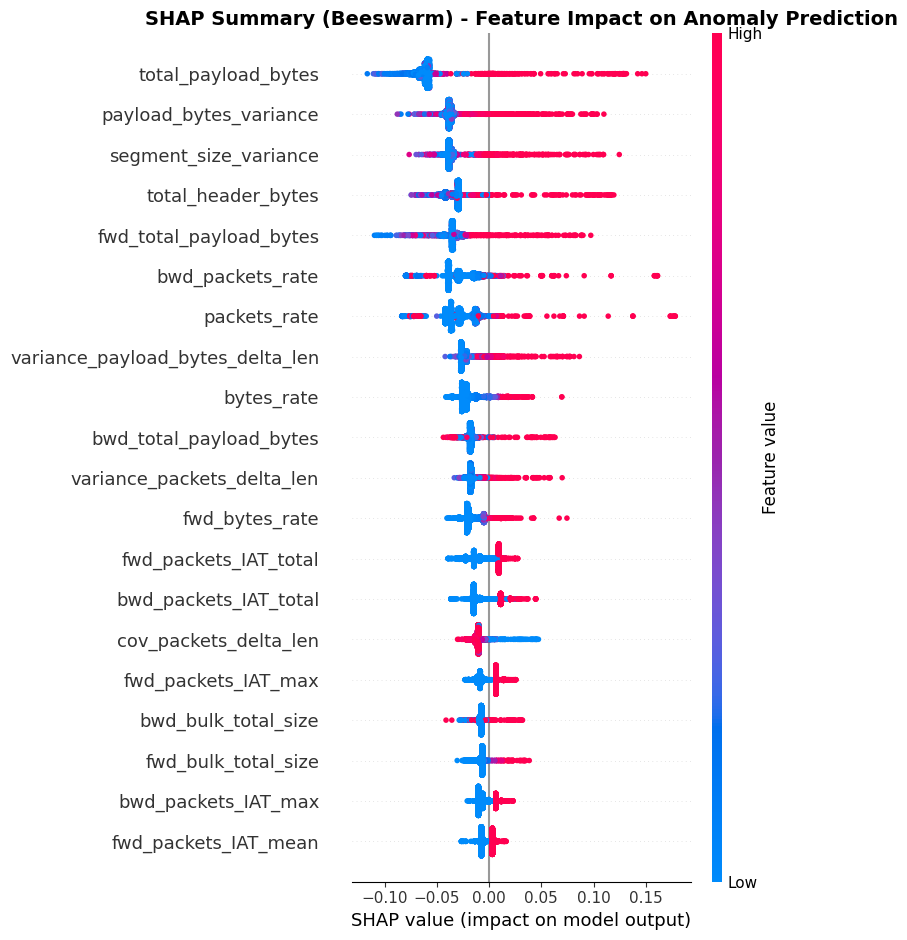

✓ Saved shap_summary_beeswarm.png


In [18]:
import matplotlib.pyplot as plt
import shap

# 1) Bar plot - global feature importance
plt.figure(figsize=(12, 7))
shap.summary_plot(shap_values_anomaly, X_test, plot_type="bar", max_display=20, show=False)
plt.title("SHAP Global Feature Importance (Anomaly Class)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{ART_DIR}/shap_summary_bar.png", dpi=300, bbox_inches="tight")
plt.show()

print("✓ Saved shap_summary_bar.png")

# 2) Beeswarm plot - feature impact distribution
plt.figure(figsize=(12, 9))
shap.summary_plot(shap_values_anomaly, X_test, max_display=20, show=False)
plt.title("SHAP Summary (Beeswarm) - Feature Impact on Anomaly Prediction", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{ART_DIR}/shap_summary_beeswarm.png", dpi=300, bbox_inches="tight")
plt.show()

print("✓ Saved shap_summary_beeswarm.png")


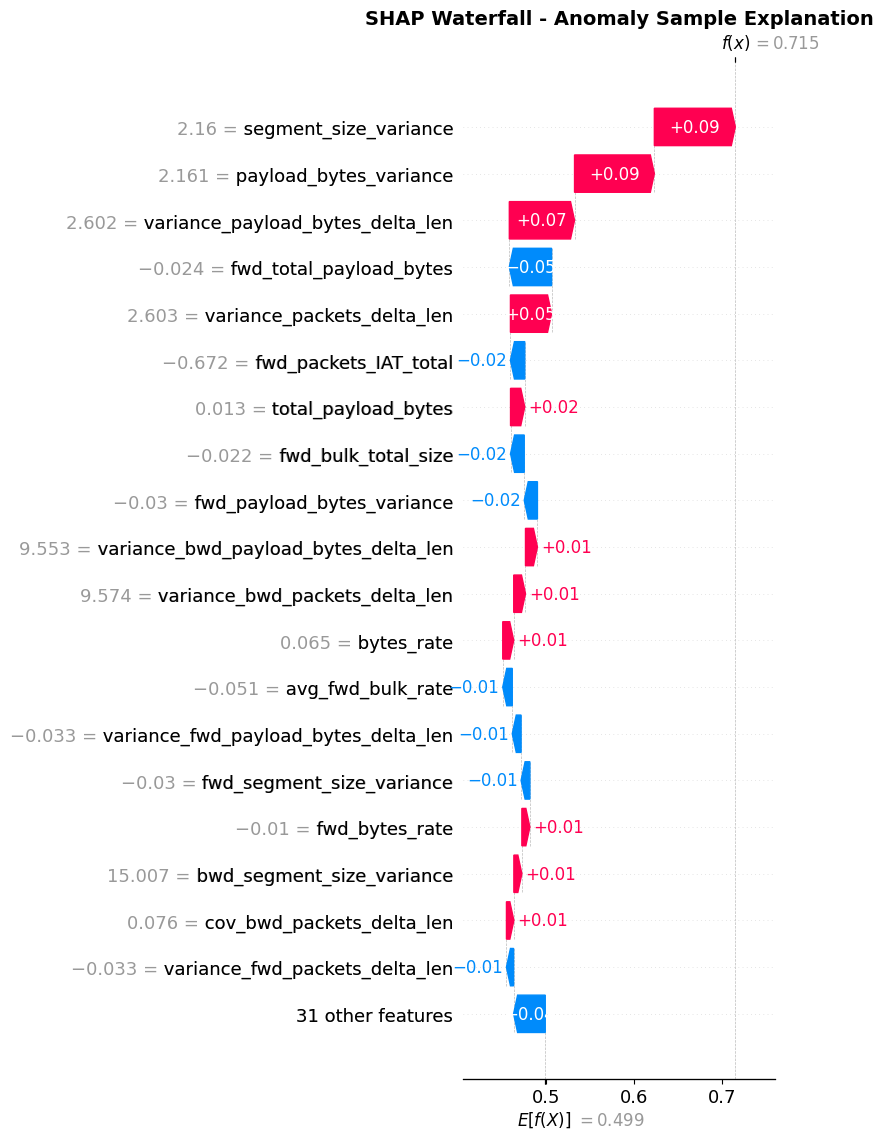

✓ Saved shap_waterfall_anomaly.png


In [19]:
# Find one true anomaly from test set
anomaly_indices = np.where(y_test.values == 1)[0]

if len(anomaly_indices) > 0:
    idx = anomaly_indices[0]  # Pick first anomaly
    x_row = X_test.iloc[idx]
    
    # Create SHAP Explanation object
    exp = shap.Explanation(
        values=shap_values_anomaly[idx],
        base_values=explainer.expected_value[1],  # Base value for class 1
        data=x_row.values,
        feature_names=X_test.columns.tolist()
    )
    
    plt.figure(figsize=(12, 6))
    shap.plots.waterfall(exp, max_display=20, show=False)
    plt.title("SHAP Waterfall - Anomaly Sample Explanation", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f"{ART_DIR}/shap_waterfall_anomaly.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    print("✓ Saved shap_waterfall_anomaly.png")
else:
    print("No anomalies found in test set")


Top SHAP feature: total_payload_bytes


<Figure size 1000x600 with 0 Axes>

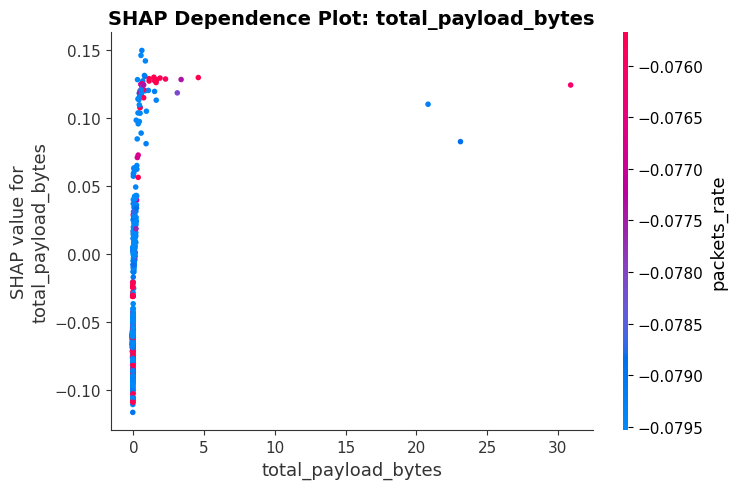

✓ Saved shap_dependence_top_feature.png


In [20]:
# Find top feature by mean |SHAP|
mean_abs_shap = np.abs(shap_values_anomaly).mean(axis=0)
top_feature_idx = np.argmax(mean_abs_shap)
top_feature = X_test.columns[top_feature_idx]

print(f"Top SHAP feature: {top_feature}")

plt.figure(figsize=(10, 6))
shap.dependence_plot(top_feature, shap_values_anomaly, X_test, show=False)
plt.title(f"SHAP Dependence Plot: {top_feature}", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{ART_DIR}/shap_dependence_top_feature.png", dpi=300, bbox_inches="tight")
plt.show()

print("✓ Saved shap_dependence_top_feature.png")
